import tarfile
tf = tarfile.open("E_coli_v4_Build_6.tar.gz")
tf.extractall()

In [1]:
import pandas as pd
import numpy as np
import os
from scipy.sparse import *
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from inspect import signature
from sklearn.metrics import average_precision_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# I have taken this part of the code to set parameters for plots from Assem Maratova's Notebook

# setting some parameters for plots
plt.style.use('seaborn')
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title 
plt.rcParams['figure.figsize'] = 10 , 6 # default figure size

# Loading Datasets

**Ecoli** consists of gene-expression data from Many Microbes Microarray Database. **regDB** contains data from RegulonDB database.

In [3]:
Ecoli = pd.read_table('C:\\Users\\ammar\\Documents\\E_coli_v4_Build_6\\avg_E_coli_v4_Build_6_exps466probes4297.tab')
Ecoli['E_coli_v4_Build_6:genes'] = Ecoli['E_coli_v4_Build_6:genes'].str.split('_').str[0]
Ecoli = Ecoli.apply(lambda x: x.astype(str).str.lower())
Ecoli = Ecoli.rename(columns = {"E_coli_v4_Build_6:genes":"Genes"})
#Ecoli.head()

In [4]:
DBfile = 'C:\\Users\\ammar\\Documents\\courses-binf305-ammar\\assignment_week_35'
regDB = pd.read_table(DBfile+'\\network_tf_gene.txt',skiprows=34,header=None, usecols=[0,1,2,4])
regDB = regDB.apply(lambda x: x.astype(str).str.lower())
regDB = regDB[(regDB[4]=='strong') & ((regDB[2]=='-') | (regDB[2]=='+'))]
regDB = regDB.drop_duplicates(subset=[0,1])
regDB = regDB.rename(columns={0: "TF", 1: "Target", 2:"Interact", 4:"Strength"})
#regDB.head()

# Filtering
Now we need to filter out genes in both datasets, such that only common genes are present in both datasets. It is achieved in the following way:

1) Selecting only those from RegulonDB database, that have same TFs and Target genes as in Ecoli database. (Also remove the rows with auto-regulation).

2) Finding the all genes in RegulonDB databases (union of TFs and Targets after filtering)

3) Using the list of genes obtain in above step to filter the Ecoli dataset.

In [5]:
tf_regdb = regDB.TF.isin(Ecoli.Genes) & regDB.Target.isin(Ecoli.Genes) & (regDB.TF != regDB.Target) 
Filt_regDB = regDB[tf_regdb]
Filt_DB_genes = np.union1d(Filt_regDB.TF.unique(),Filt_regDB.Target.unique())
Ecoli_Filt = Ecoli[Ecoli.Genes.isin(Filt_DB_genes)]

# Adjacency and Correlation Matrix 

Create adjacency matrix from the regulonDB filtered data.

Create pairwise correlation matrix from the Ecoli filtered data.

Both matrices should be of same dimensions (849 x 849)

In [6]:
def AdjMatrix(D,AllGenes):
    row = np.empty(len(D)).astype(float)
    col = np.empty(len(D)).astype(float)
    data = np.empty(len(D)).astype(float)

    for i in range(len(D)):
        temp = D.iloc[i]
        row[i] = np.where(AllGenes == temp[0])[0][0]
        col[i] = np.where(AllGenes == temp[1])[0][0]
        if (temp[2] == '+'):
            data[i] = 1
        else:
            data[i] = -1
    return(data,row,col)

In [7]:
data,row,col = AdjMatrix(Filt_regDB,Filt_DB_genes)
Adj = csr_matrix((data, (row, col)), shape=(len(Filt_DB_genes), len(Filt_DB_genes)))
Adj.setdiag(0)
Adj = Adj.toarray()
print(Adj.shape)

(849, 849)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [8]:
data = (Ecoli_Filt.iloc[:,1:].to_numpy()).astype('float')
Corr = np.corrcoef(data)
print(Corr.shape)

(849, 849)


# Distribution of pairwise correlation values
Here we plot the distribution of pairwise correlation values, for both activators and repressors.

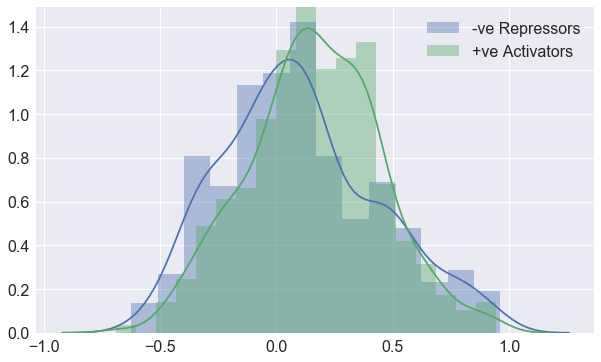

In [9]:
x = Corr[Adj==-1]
y = Corr[Adj==1]

sns.distplot(x,label='-ve Repressors')
sns.distplot(y,label='+ve Activators')
plt.legend(loc='best')

In [10]:
# Adjacency and Correlation matrices are converted to absolute values for next parts of the assignment.
AbsCorr = np.abs(Corr)
AdjMat = np.abs(Adj)

# Precision Recall / ROC Curves

Now we compute the precision recall curve for the absolute correlation values. 

First of all we need to locate the TFs in both the datasets. Rows corresponding to TFs in Adjacency matrix will be considered as our *gold standard* values, and Rows corresponding to TFs in correlation matrix will be considered as our prediction scores for expression level of each gene by each TF.

In [11]:
temp_row = np.unique(AdjMat.nonzero()[0]) # these are TFs
AbsCorr[temp_row,temp_row] = 0
temp_Test = AdjMat[temp_row,:]
temp_Pred = AbsCorr[temp_row,:]
#np.unique(AdjMat.nonzero()[1]).shape

In [12]:
def prec_recall_curve(true_scores, predict_scores):
    average_precision = average_precision_score(true_scores, predict_scores)
    precision, recall, _ = precision_recall_curve(true_scores, predict_scores)
    plt.plot(recall,precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 0.7])
    plt.xlim([0.0, 0.14])
    plt.title('Precision-Recall Curve: AUPRC={0:0.2f}'.format(
          average_precision))

def roc_fig(true_scores, predict_scores):
    fpr, tpr, _ = roc_curve(true_scores, predict_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (AUROC = {0:0.2f})'.format(roc_auc))

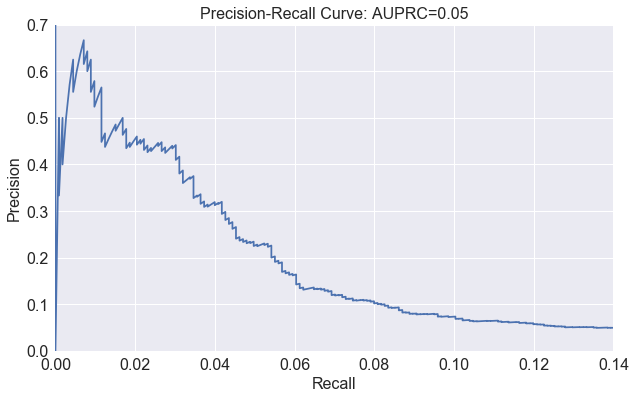

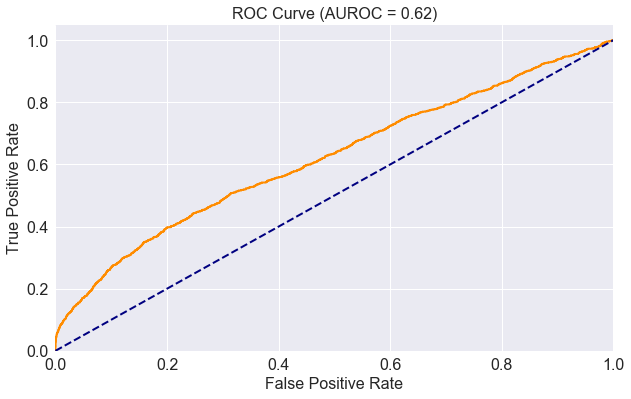

In [13]:
prec_recall_curve(temp_Test.ravel(),temp_Pred.ravel())
roc_fig(temp_Test.ravel(),temp_Pred.ravel())

# Predicting the expressiong level using Machine learning

This part was the most tricky for me and I am still not sure if this is correct way to do it. The procedure I used is as follows:

1) Split the Ecoli data to data containing only TF expression levels (*Ecoli_TF*) and data containing expression levels for every genes (*Ecoli_Target*)

2) After that we need to train separate models for every target gene.

3) In every model the gene expression level of the given gene will be conisdered as output (target), where as the expression level of all the TFs will be considered as inputs.

4) Therefore, for every model the input will remain same but the output would be different.

5) After training of all models, the coefficients for every prediction will be considered as prediction score similar to the way it was considered when using pairwise correlations.

6) I have used **Lasso Regression** to predicting the expression level below but I obtained similar plots when using **Elastic Net** as well.

In [14]:
Ecoli_TF  = Ecoli_Filt.iloc[temp_row,1:].values.astype('float')
Ecoli_Target  = Ecoli_Filt.iloc[:,1:].values.astype('float')

In [33]:
W = []
from tqdm import tqdm_notebook as tqdm
for i in tqdm(range(Ecoli_Target.shape[0])):
    clf = linear_model.Lasso(alpha=0.01)
    #clf = linear_model.ElasticNet(alpha=0.1, l1_ratio=0.1)
    #clf = RandomForestRegressor(max_depth=10 ,n_estimators=20)
    #clf.fit(Ecoli_TF.T,Ecoli_Target[i]) # for random tree
    clf.fit(Ecoli_TF.T,Ecoli_Target[i].reshape(-1,1))
    W.append(clf.coef_)
    #W.append(clf.feature_importances_)
    

HBox(children=(IntProgress(value=0, max=849), HTML(value='')))

In [34]:
#Ecoli_Target.shape[0]/10
W = np.array(W).T
#print(W.shape)
#print(temp_Test.shape)

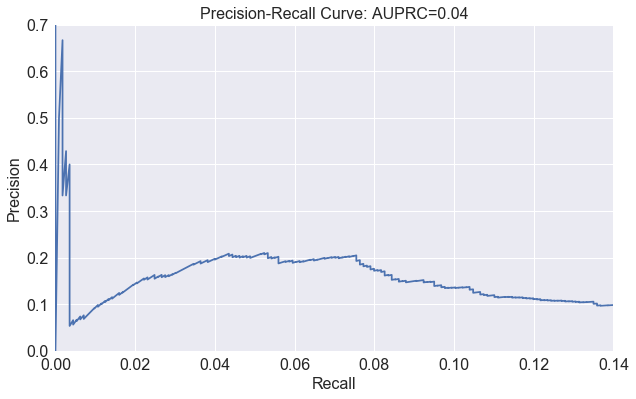

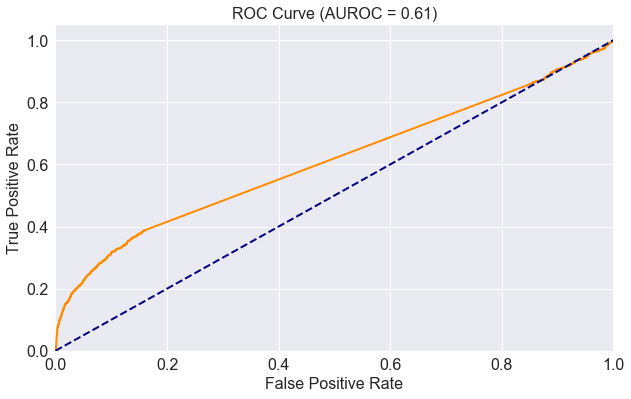

In [35]:
prec_recall_curve(temp_Test.ravel(),W.ravel())
roc_fig(temp_Test.ravel(),W.ravel())

# Conclusion

Looking at the figures generated by both **pairwise correlation** and **lasso regression**, I dont see much differene in the performance of two methods. **Pairwise correlation** appears to perform slightly better with *AUPRC = 0.05* and *AUROC=0.62*, as compared to *AUPRC = 0.04* and *AUROC=0.61* for **Lasso Regression**.